Water Network: d2_Sample_input_cycle_hanoi 

Solve the original nonconvex optimization problem using IPOPT 
Ipopt 3.12.13: outlev = 0
expect_infeasible_problem = yes
bound_push = 0.001
bound_frac = 0.001
warm_start_init_point = yes


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt
******************************************************************************

 
Ipopt 3.12.13: Optimal Solution Found

suffix ipopt_zU_out OUT;
suffix ipopt_zL_out OUT;
Objective:  6217280.76683498
solve_result:  solved
Solve_time: 0.935719 

Generate the acyclic network using ipopt solution
Fix the flow direction in optimization model and solve the updated model
Ipopt 3.12.13: outlev = 0
expect_infeasible_problem = yes
bound_push = 0.001
bound_frac = 0

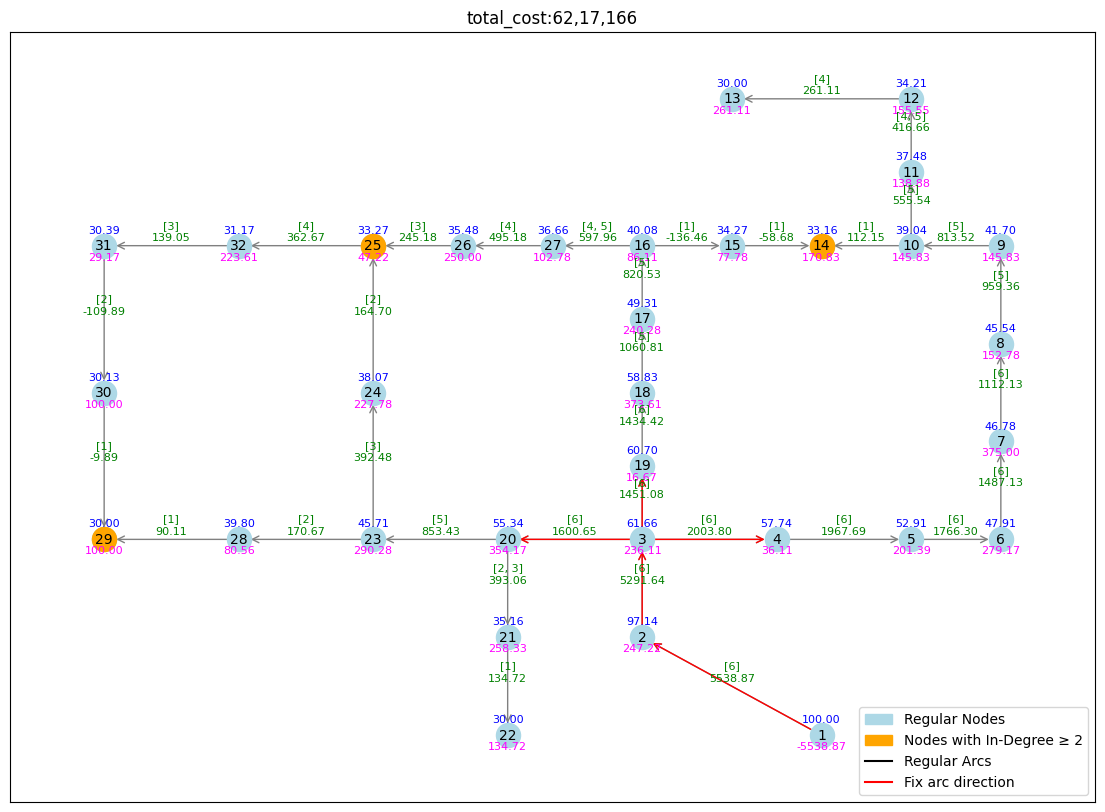

Iteration : 1
Acyclic network arcs direction:  [(1, 2), (2, 3), (3, 4), (3, 19), (3, 20), (4, 5), (5, 6), (6, 7), (7, 8), (8, 9), (9, 10), (10, 11), (10, 14), (11, 12), (12, 13), (15, 14), (16, 15), (16, 27), (17, 16), (18, 17), (19, 18), (20, 21), (20, 23), (21, 22), (23, 24), (23, 28), (24, 25), (25, 32), (26, 25), (27, 26), (28, 29), (30, 29), (31, 30), (32, 31)]
Fixed arc set: [(1, 2), (2, 3), (3, 4), (3, 19), (3, 20)]
Node: 14 in_degree: 2
Acyclic True
Ipopt 3.12.13: outlev = 0
expect_infeasible_problem = yes
bound_push = 0.001
bound_frac = 0.001
warm_start_init_point = yes


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt
******************************************************************************

 
Ipopt 3.12.13: Optimal 

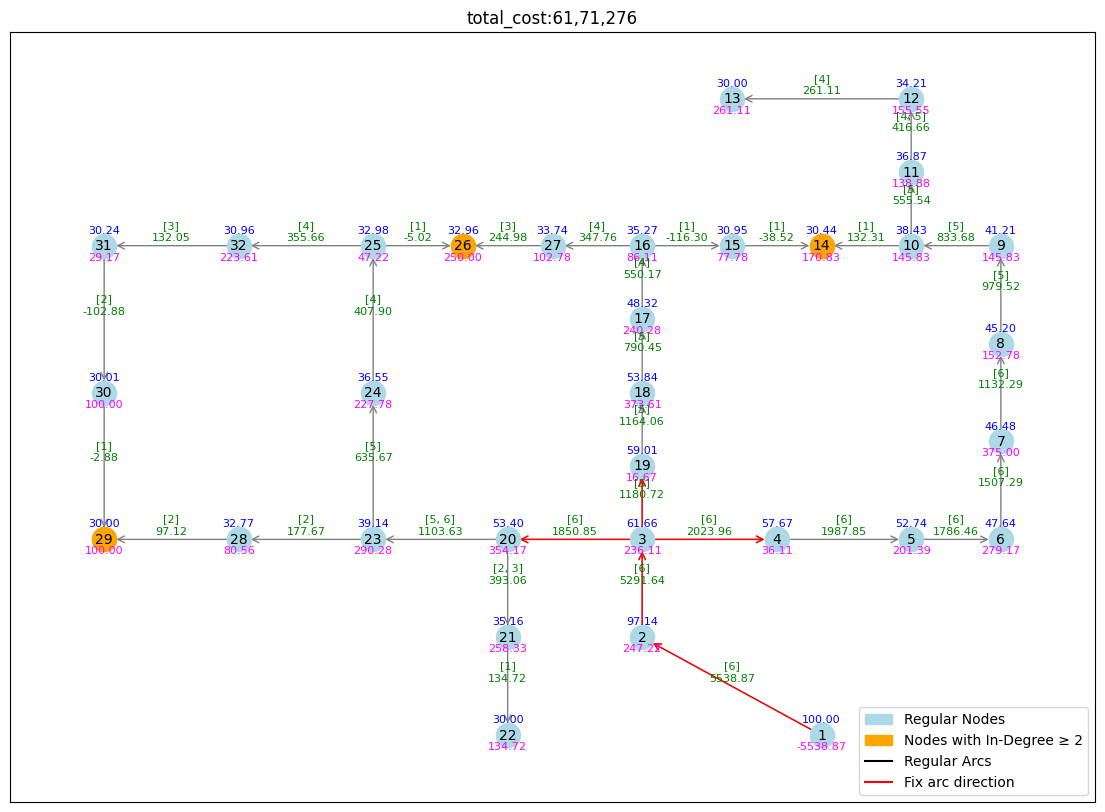

NetworkXError: The edge 29-30 not in graph.

In [14]:
import networkx as nx
from amplpy import AMPL
import matplotlib.pyplot as plt
import numpy as np
import time
import copy
import sys
import os
import contextlib
from sklearn.decomposition import PCA
import random

import matplotlib.lines as mlines
import matplotlib.patches as mpatches

import warnings
warnings.filterwarnings("ignore")

class WaterNetworkOptimizer:
    def __init__(self, model_file, data_file, data_number):
        self.ampl = AMPL()
        self.model_file = model_file
        self.data_file = data_file
        self.data_number = data_number
        self.total_cost = None
        self.network_graph = None
        self.solve_result = None
        self.solver_time = 0

    def load_model(self):
        """Load the model and data."""
        self.ampl.reset()
        self.ampl.read(self.model_file)
        self.ampl.read_data(self.data_file)
        
        self.nodes = self.ampl.getSet('nodes')
        self.source = self.ampl.getSet('Source')
        self.arcs = self.ampl.getSet('arcs')
        self.pipes = self.ampl.getSet('pipes')

    def create_digraph(self):
        nodes_list = [i for i in self.ampl.getSet('nodes')]
        edges_list = self.ampl.getSet('arcs').to_list()
        self.network_graph = nx.DiGraph()
        self.network_graph.add_nodes_from(nodes_list)
        self.network_graph.add_edges_from(edges_list)
        print(nodes_list)
        print(edges_list)

    def display_results(self):
        """Display relevant results from the optimization."""
        self.ampl.eval("display {(i,j) in arcs, k in pipes:l[i,j,k]>1} l[i,j,k];")
        self.ampl.eval("display {(i,j) in arcs}: q[i,j];")
        self.ampl.eval("display h;")
        self.ampl.eval("display solve_result;")
        self.total_cost = self.ampl.get_objective("total_cost").value()
        print("Objective:", self.total_cost)
        # self.ampl.eval("display {(i,j) in arcs} h[i] - h[j];")
        # self.ampl.eval("display {i in nodes} h[i] - (E[i] + P[i]);")

    def display_best_results(self,ampl):
        ampl.eval("display {(i,j) in arcs}: q[i,j];")
        ampl.eval("display l;")
        ampl.eval("display h;")
        ampl.eval("display solve_result;")
        total_cost = ampl.get_objective("total_cost").value()
        print("Objective:", total_cost)
    
    # def plot_graph(self):
    #     print("Edges of the graph:",self.network_graph.edges())
    #     plt.figure(figsize=(10, 8))
    #     nx.draw_spectral(self.network_graph, with_labels=True)
    #     plt.show()


    def plot_graph1(self, super_source_out_arc=None, best_arc=None,current_cost = None, iteration= 1):
        # print("Edges of the graph:", self.network_graph.edges())
        indegree_2_or_more = [node for node, indeg in self.network_graph.in_degree() if indeg >= 2]
        
        plt.figure(figsize=(10, 8))
        pos = nx.spectral_layout(self.network_graph)
        nx.draw_networkx_nodes(self.network_graph, pos, node_color='lightblue', node_size=200)
        
        if indegree_2_or_more:
            nx.draw_networkx_nodes(self.network_graph, pos, nodelist=indegree_2_or_more, node_color='orange', node_size=200)
            
        nx.draw_networkx_labels(self.network_graph, pos)
        nx.draw_networkx_edges(self.network_graph, pos, edge_color='black')
        
        if super_source_out_arc:
            nx.draw_networkx_edges(self.network_graph, pos, edgelist=super_source_out_arc, edge_color='red', width=1)
            
        if best_arc:
            nx.draw_networkx_edges(self.network_graph, pos, edgelist=[best_arc], edge_color='magenta', width=1)
            
        plt.title(f"total_cost:{self.total_cost}")
        plt.savefig(f"/home/nitishdumoliya/waterNetwork/model/figure/d{self.data_number}_iteration_{iteration}.png")
        plt.box(False)
        plt.show()

    def plot_graph(self, super_source_out_arc=None, current_cost = None, iteration = 1, edge_weights= None, h = None, D = None, arc=(0,0), l ={}, C = {}):
        # self.network_graph = nx.DiGraph()
        # self.network_graph.add_edges_from(edges)
        # Node positions as per your specifications
        
        new_positions0 = {
             2 : (2000.00, 3000.00),
             3 : (1000.00, 3000.00),        
             4 : (2000.00, 2000.00),        
             5 : (1000.00, 2000.00),       
             6 : (2000.00, 1000.00),       
             7 : (1000.00, 1000.00),      
             1 : (3000.00, 3000.00)     
            }  
        
        new_positions1 = {
            2: (6000.00, 2000.00),
            3: (6000.00, 4000.00),
            4: (7500.00, 4000.00),
            5: (9000.00, 4000.00),
            6: (10000.00, 4000.00),
            7: (10000.00, 6000.00),
            8: (10000.00, 8000.00),
            9: (10000.00, 10000.00),
            10: (9000.00, 10000.00),
            11: (9000.00, 11500.00),
            12: (9000.00, 13000.00),
            13: (7000.00, 13000.00),
            14: (8000.00, 10000.00),
            15: (7000.00, 10000.00),
            16: (6000.00, 10000.00),
            17: (6000.00, 8500.00),
            18: (6000.00, 7000.00),
            19: (6000.00, 5500.00),
            20: (4500.00, 4000.00),
            21: (4500.00, 2000.00),
            22: (4500.00, 0.00),
            23: (3000.00, 4000.00),
            24: (3000.00, 7000.00),
            25: (3000.00, 10000.00),
            26: (4000.00, 10000.00),
            27: (5000.00, 10000.00),
            28: (1500.00, 4000.00),
            29: (0.00, 4000.00),
            30: (0.00, 7000.00),
            31: (0.00, 10000.00),
            32: (1500.00, 10000.00),
            1: (8000.00, 0.00)
        }       
        
        new_positions16 = {
            2: (5679.61, 9538.83),
            3: (4862.46, 9538.83),
            4: (2750.81, 9474.11),
            5: (1852.75, 8357.61),
            6: (1974.11, 6076.05),
            7: (1974.11, 5149.68),
            8: (4235.44, 5076.86),
            9: (6411.81, 5093.04),
            10: (5412.62, 7888.35),
            11: (4510.52, 8264.56),
            12: (3033.98, 9243.53),
            13: (2301.78, 8078.48),
            14: (2944.98, 7669.90),
            15: (3786.41, 7139.97),
            16: (4830.10, 6480.58),
            17: (7099.51, 8438.51),
            18: (5505.66, 8450.65),
            19: (3563.92, 8839.00),
            20: (3167.48, 7532.36),
            21: (2730.58, 7285.60),
            22: (3511.33, 6666.67),
            23: (4097.90, 6286.41),
            24: (3337.38, 5121.36),
            25: (4530.74, 6011.33),
            26: (4215.21, 7783.17),
            27: (5194.17, 7055.02),
            28: (5218.45, 5089.00),
            29: (5622.98, 5999.19),
            30: (5950.65, 5796.93),
            31: (6614.08, 7621.36),
            32: (5380.26, 7544.50),
            33: (6318.77, 7281.55),
            34: (6549.35, 7212.78),
            35: (6585.76, 6092.23),
            36: (7152.10, 6104.37),
            1: (7111.65, 7532.36),
            37: (7669.90, 7783.17)
        }

        # # Update node positions
        pos = new_positions1
        # pos = nx.spectral_layout(self.network_graph)

        plt.figure(figsize=(14, 10))
        cmap = plt.cm.plasma

        # Draw nodes with default color (lightblue)
        nx.draw_networkx_nodes(self.network_graph, pos, node_color='lightblue', node_size=300, label='Regular Nodes')
        
        cost = {}

        for (i,j) in self.ampl.getSet('arcs'):
            cost[i,j] = sum(l[i,j,k] * C[k] for k in self.ampl.getSet('pipes'))
        
        if cost:
            for (u, v), value in cost.items():
                # if self.network_graph.has_edge(u, v):
                mid_x = (pos[u][0] + pos[v][0]) / 2  # Midpoint x-coordinate
                mid_y = (pos[u][1] + pos[v][1]) / 2  # Midpoint y-coordinate
                # plt.text(mid_x, mid_y+500 , f"{value:.2f}", fontsize=8, color='green', ha='center')  # Annotate weight on edge
                # plt.text(mid_x, mid_y + 100, f"{value:.2f}", fontsize=8, color='green', ha='center')  # Annotate weight on edge
        
        # Highlight nodes with in-degree >= 2
        indegree_2_or_more = [node for node, indeg in self.network_graph.in_degree() if indeg >= 2]
        if indegree_2_or_more:
            nx.draw_networkx_nodes(self.network_graph, pos, nodelist=indegree_2_or_more, node_color='orange', node_size=300, label='Nodes with In-Degree ≥ 2')

        # Draw node labels
        nx.draw_networkx_labels(self.network_graph, pos, font_size=10)

        # Draw edges
        nx.draw_networkx_edges(self.network_graph, pos, arrowstyle="->", arrowsize=12, edge_color='gray', label='Regular Arcs')

        # Highlight super-source edges in red
        if super_source_out_arc:
            nx.draw_networkx_edges(self.network_graph, pos, edgelist=super_source_out_arc,arrowstyle="->", arrowsize=12, edge_color='red', width=1, label='Fix arc direction')

        # Highlight the best arc in magenta
        # if best_arc:
        #     nx.draw_networkx_edges(self.network_graph, pos, edgelist=[best_arc],arrowstyle="->", arrowsize=12, edge_color='magenta', width=1, label = 'Best arc')
        # Annotate node demands
        if h:
            for node, (x, y) in pos.items():
                demand = h.get(node, 0)  # Get the head for the node, default to 0 if not in dictionary
                plt.text(x, y + 250, f"{demand:.2f}", fontsize=8, color='blue', ha='center')  # Annotate demand below the node
        if D:
            for node, (x, y) in pos.items():
                demand = D.get(node, 0)  # Get the demand for the node, default to 0 if not in dictionary
                plt.text(x, y - 300, f"{demand:.2f}", fontsize=8, color='magenta', ha='center')  # Annotate demand below the node

        # Annotate edge weights
        if edge_weights:
            for (u, v), weight in edge_weights.items():
                # if self.network_graph.has_edge(u, v):
                mid_x = (pos[u][0] + pos[v][0]) / 2  # Midpoint x-coordinate
                mid_y = (pos[u][1] + pos[v][1]) / 2  # Midpoint y-coordinate
                plt.text(mid_x, mid_y+100 , f"{weight:.2f}", fontsize=8, color='green', ha='center')  # Annotate weight on edge
        pipe_dia_arc = {}
        for (i,j) in self.arcs:
            list_=[]
            for k in self.pipes:
                if l[i,j,k]>= 1e-5:
                    list_.append(k)
            pipe_dia_arc[i,j] = list_
            
        if pipe_dia_arc:
            for (u, v), weight in pipe_dia_arc.items():
                # if self.network_graph.has_edge(u, v):
                mid_x = (pos[u][0] + pos[v][0]) / 2  # Midpoint x-coordinate
                mid_y = (pos[u][1] + pos[v][1]) / 2  # Midpoint y-coordinate
                # plt.text(mid_x, mid_y+550 , f"{weight}", fontsize=8, color='purple', ha='center')  # Annotate weight on edge
                plt.text(mid_x, mid_y+350 , f"{weight}", fontsize=8, color='green', ha='center')  # Annotate weight on edge
        
        # Create legend
        regular_node_patch = mpatches.Patch(color='lightblue', label='Regular Nodes')
        indegree_node_patch = mpatches.Patch(color='orange', label='Nodes with In-Degree ≥ 2')
        regular_edge_line = mlines.Line2D([], [], color='black', label='Regular Arcs')
        super_source_edge_line = mlines.Line2D([], [], color='red', label='Fix arc direction')
        # best_edge_line = mlines.Line2D([], [], color='magenta', label='Best Arc')
        plt.legend(handles=[regular_node_patch, indegree_node_patch, regular_edge_line, super_source_edge_line], loc='lower right')
        
        cost = round(self.total_cost)
        # res = f"{cost:,}"
        plt.title(f"total_cost:{self.format_indian_number(cost)}")
        (u,v) = arc
        plt.savefig(f"/home/nitishdumoliya/waterNetwork/model/figure/d{self.data_number}_iteration_{iteration}_{u}_{v}.png")
        plt.box(True)
        plt.show()
        
    def cycle_basis(self):
        root = self.ampl.getSet('Source').to_list()[0]
        nodes_list = [i for i in self.ampl.getSet('nodes')]
        edges_list = self.ampl.getSet('arcs').to_list() 
        uwg = nx.Graph()
        uwg.add_nodes_from(nodes_list)
        uwg.add_edges_from(edges_list)
        # print("Edges in the undirected graph:", edges_list)
        print("cycle basis for given water network: ",nx.cycle_basis(uwg, root))
        
    def generate_random_acyclic_from_solution(self):
        print("Generate the acyclic network using ipopt solution")
        nodes_list = [i for i in self.ampl.getSet('nodes')]
        edges_list = self.ampl.getSet('arcs').to_list()
        
        self.network_graph = nx.DiGraph()
        self.network_graph.add_nodes_from(nodes_list)
        
        q = self.ampl.getVariable('q').getValues().toDict()
        for (i,j) in edges_list:
            if q[i,j] >= 0:
                self.network_graph.add_edge(i,j)
            else:
                self.network_graph.add_edge(j,i)

    def generate_random_acyclic_graph(self):
        uwg = nx.Graph()
        nodes_list = [i for i in self.ampl.getSet('nodes')]
        edges_list = self.ampl.getSet('arcs').to_list()
        uwg.add_nodes_from(nodes_list)
        uwg.add_edges_from(edges_list)
        print("Edges in the undirected graph:", edges_list)
        
        # Generate a random spanning tree using Wilson's algorithm
        random_tree = nx.random_spanning_tree(uwg)
        
        # Retrieve the root from the AMPL source set
        root_l = self.ampl.getSet('Source').to_list()
        root = root_l[0]
        print("Root node:", root)

        # Ensure the root is present in the random tree
        if root not in random_tree.nodes:
            raise ValueError("The specified root must be a node in the graph.")

        # Create a directed graph from the random tree starting from the specified root
        self.network_graph = nx.DiGraph()
        visited = set()

        def dfs(node):
            visited.add(node)
            for neighbor in random_tree.neighbors(node):
                if neighbor not in visited:
                    self.network_graph.add_edge(node, neighbor) 
                    dfs(neighbor)

        # Start DFS from the specified root
        dfs(root)

        # Draw the initial directed tree
        plt.figure(figsize=(15, 10))
        plt.subplot(121)
        nx.draw_spectral(self.network_graph, with_labels=True, node_color='lightgreen', font_weight='bold', arrows=True)
        plt.title("Directed Spanning Tree")

        # Add remaining edges from the original graph and check for cycles
        for u, v in uwg.edges():
            if not self.network_graph.has_edge(u, v):  
                self.network_graph.add_edge(u, v)  
                if not nx.is_directed_acyclic_graph(self.network_graph):  
                    self.network_graph.remove_edge(u, v)  
                    self.network_graph.add_edge(v, u)  

        # Draw the final directed graph after adding remaining edges
        plt.subplot(122)
        nx.draw_spectral(self.network_graph, with_labels=True, node_color='lightgreen', font_weight='bold', arrows=True)
        plt.title("Acyclic Directed Graph")
        plt.show()

    def update_model(self):
        # print("Fix the arcs direction using the acyclic network\n")
        edges_list = [(arc[0],arc[1]) for arc in self.ampl.getSet('arcs')]
        for edge in self.network_graph.edges:
            i, j = edge
            if edge in edges_list:
                self.ampl.eval(f"s.t. flow_direction{i}_{j}: q[{i},{j}] >=0;")
                # self.ampl.eval(f"s.t. head_bound_left{i}_{j}: E[{j}]+P[{j}] <= h[{j}];")
                # self.ampl.eval(f"s.t. head_bound_right{i}_{j}: E[{j}] + P[{j}] <= h[{i}];")
            else:
                self.ampl.eval(f"s.t. flow_direction{i}_{j}: q[{j},{i}] <=0;")
                # self.ampl.eval(f"s.t. head_bound_left{i}_{j}: E[{i}]+P[{i}] <= h[{i}];")
                # self.ampl.eval(f"s.t. head_bound_right{i}_{j}: E[{i}] + P[{i}] <= h[{j}];")  

    def update_model_lp(self):
        # print("Fix the arcs direction using the acyclic network\n")
        edges_list = [(arc[0],arc[1]) for arc in self.ampl.getSet('arcs')]
        for edge in self.network_graph.edges:
            i, j = edge
            if edge in edges_list:
                self.ampl.eval(f"s.t. flow_direction{i}_{j}: q_lp[{i},{j}] >=0;")
                # self.ampl.eval(f"s.t. head_bound_left{i}_{j}: E[{j}]+P[{j}] <= h[{j}];")
                # self.ampl.eval(f"s.t. head_bound_right{i}_{j}: E[{j}] + P[{j}] <= h[{i}];")
            else:
                self.ampl.eval(f"s.t. flow_direction{i}_{j}: q_lp[{j},{i}] <=0;")
                # self.ampl.eval(f"s.t. head_bound_left{i}_{j}: E[{i}]+P[{i}] <= h[{i}];")
                # self.ampl.eval(f"s.t. head_bound_right{i}_{j}: E[{i}] + P[{i}] <= h[{j}];") 
    
    def updated_data_file(self):
        edges_list = [(arc[0],arc[1]) for arc in self.ampl.getSet('arcs')]
        # Example: Update parameter values
        q = self.ampl.getVariable('q').getValues().to_dict()
        L = self.ampl.getParameter('L').getValues().to_dict()
        for (i,j), value in q.items():
            self.ampl.getParameter('arcs').setValues({
                ('NewYork', 'LosAngeles'): 2500,
                ('NewYork', 'Chicago'): 750,
                ('LosAngeles', 'Chicago'): 1900
            })

    def is_valid_edge(self, source, target):
        """Check if adding the directed edge (source -> target) maintains acyclicity."""
        self.network_graph.add_edge(source, target)  # Temporarily add the edge
        is_dag = nx.is_directed_acyclic_graph(self.network_graph)  # Check for acyclicity
        self.network_graph.remove_edge(source, target)  # Remove the edge after checking
        return is_dag  # Return True if it maintains acyclicity     
    
    def check_incoming_arcs(self):
        root = list(self.ampl.getSet('Source'))[0]
        # Iterate over all nodes in the graph
        for node in self.network_graph.nodes():
            # Skip the root node
            if node == root:
                continue
            # Check if the in-degree of the node is at least 1
            if self.network_graph.in_degree(node) < 1:
                # print(f"Node {node} does not have any incoming arcs.")
                return False
        # print("All nodes except the root have at least one incoming arc.")
        return True
            
    def format_indian_number(self,num):
        num_str = str(num)
        if len(num_str) <= 3:
            return num_str
        else:
            # Split the number into the last three digits and the rest
            last_three = num_str[-3:]
            remaining = num_str[:-3]
            # Add commas every two digits in the remaining part
            remaining = ','.join([remaining[max(i - 2, 0):i] for i in range(len(remaining), 0, -2)][::-1])
            return remaining + ',' + last_three

    def fix_leaf_arc_flow(self):
        graph = nx.Graph()
        arc_set = self.ampl.getSet('arcs').to_list()  
        graph.add_edges_from(arc_set)
        D = self.ampl.getParameter('D').getValues().to_dict()  
        source = self.ampl.getSet('Source').to_list()[0]
        fixed_arcs = set()
        # print("\nPresolve the model for fixing the flow value in the leaf arcs")
        # print("Source:",self.ampl.getSet('Source').to_list())

        while True:
            leaf_nodes = [node for node in graph.nodes if graph.degree[node] == 1]
            # print("leaf_nodes:", leaf_nodes)
            if not leaf_nodes:  
                break

            for leaf in leaf_nodes:
                neighbor = next(graph.neighbors(leaf))
                if (neighbor, leaf) in arc_set:
                    edge = (neighbor, leaf)
                    if edge not in fixed_arcs:  
                        if leaf == source:
                            flow_value = D[leaf]
                            D[neighbor] = (D[neighbor]+flow_value)
                            source = neighbor
                        else:
                            flow_value = D[leaf]
                            D[neighbor] = D[neighbor] + flow_value
                        self.ampl.eval(f"s.t. fix_q_{edge[0]}_{edge[1]}: q[{edge[0]},{edge[1]}] = {flow_value};")
                        # print(f"Fixing flow for arc {edge}: {flow_value}")
                        fixed_arcs.add(edge)  

                    graph.remove_node(leaf)
                else:
                    edge = (leaf, neighbor)
                    if edge not in fixed_arcs:  
                        if leaf == source:
                            flow_value = -D[leaf]
                            D[neighbor] = D[neighbor]-flow_value
                            source = neighbor
                            self.ampl.eval(f"s.t. fix_q_{edge[0]}_{edge[1]}: q[{edge[0]},{edge[1]}] = {flow_value};")
                        elif neighbor == source:
                            flow_value = -D[leaf]
                            D[neighbor] = D[neighbor] - D[leaf] 
                            self.ampl.eval(f"s.t. fix_q_{edge[0]}_{edge[1]}: q[{edge[0]},{edge[1]}] = {flow_value};")
                        else:
                            flow_value = -D[leaf]
                            D[neighbor] += -flow_value
                            self.ampl.eval(f"s.t. fix_q_{edge[0]}_{edge[1]}: q[{edge[0]},{edge[1]}] = {flow_value};")
                        # print(f"Fixing flow for arc {edge}: {flow_value}")
                        fixed_arcs.add(edge)  
                    graph.remove_node(leaf)
        # print("All leaf arc flows have been fixed.")


    def is_cycle(self, graph, start_node, end_node, visited_copy, parent):
        visited_copy[start_node] = True
        # print(f"Is node {end_node} in cycle?")
        for neighbor in graph.neighbors(start_node):
            # print("visited",neighbor,visited_copy[neighbor])
            if not visited_copy[neighbor]:
                # print("neighbor of node", start_node, "is", neighbor)
                isCycle = self.is_cycle(graph, neighbor, end_node, visited_copy, start_node)
                if isCycle:
                    return True
            else:
                # print("parent:", parent)
                if parent != neighbor:
                    if end_node == neighbor:
                        # print(f"Node {end_node} is in cycle")
                        return True
        return False

    def presolve(self, graph, node, visited, parent, set_arc):
        visited_copy = visited.copy()
        # print(visited_copy)
        isCycle = self.is_cycle(graph, node, node, visited_copy, parent)
        print(f"Is node {node} in cycle?",isCycle)
        visited[node] = True
        if isCycle:
            for neighbor in graph.neighbors(node):
                if parent!=neighbor:
                    set_arc.append((node,neighbor))
                    print("Fix the arc", (node, neighbor))
            return set_arc
        else:
            for neighbor in graph.neighbors(node):
                if parent != neighbor:
                    set_arc.append((node,neighbor))
                    # print(set_arc)
                    print("Fix the arc", (node, neighbor))
                    # print("neighbor:", neighbor)
                    self.presolve(graph, neighbor, visited, node, set_arc)
        return set_arc

    def fix_arc_set(self):
        graph = nx.Graph()
        arc_set = self.ampl.getSet('arcs').to_list()
        graph.add_edges_from(arc_set)
        visited = {node: False for node in graph.nodes()}
        source = self.ampl.getSet('Source').to_list()[0]
        set_arc = []
        print("\nPresolve the model for fixing the arc direction")
        set_ = self.presolve(graph, source, visited, -1, set_arc)
        print("fixed arc direction:",set_, "\n") 
        return set_

    def generate_initial_points(self):
        # self.ampl = AMPL()
        self.ampl.reset()
        self.ampl.read("/home/nitishdumoliya/waterNetwork/model/mccormic_rel.mod")
        self.ampl.read_data(self.data_file)
        self.ampl.option['solver'] = 'cplexamp'
        self.update_model()
        self.ampl.solve()
        l_solution = self.ampl.get_variable("l").get_values().to_dict()
        q_solution = self.ampl.get_variable("q").get_values().to_dict()
        h_solution = self.ampl.get_variable("h").get_values().to_dict()
        
        print("total_cost:", self.ampl.get_objective("total_cost").value())

#         self.ampl.reset()
#         self.ampl.read("/home/nitishdumoliya/waterNetwork/model/potentialBasedFlow/content_model.mod")
#         self.ampl.read_data(self.data_file)
#         self.ampl.option['solver'] = 'ipopt'
#         self.ampl.option['presolve_eps'] = '1.19e-08'
#         self.update_model()
        
#         for (i, j, k) in l_solution.keys():
#             if l_solution[i, j, k] >= 1:
#                 self.ampl.eval(f"s.t. fix_length_{i}_{j}_{k}: l[{i},{j},{k}]={l_solution[i, j, k]};")
        
#         self.ampl.solve()
#         # l_solution = self.ampl.get_variable("l").get_values().to_dict()
#         q_solution = self.ampl.get_variable("q").get_values().to_dict()
#         # h_solution = self.ampl.get_variable("h").get_values().to_dict()
#         print("total_cost:", self.ampl.get_objective("total_cost").value())
        
        self.ampl.reset()
        self.ampl.read("../lpNlp/lp_model.mod")
        self.ampl.read_data(self.data_file)
        self.ampl.option['solver'] = 'cplexamp'
        # self.update_model_lp()   
        
        for (i, j), value in q_solution.items():
            self.ampl.param['q_lp'][i, j] = value
        
        self.ampl.solve()
        l_solution = self.ampl.get_variable("l_lp").get_values().to_dict()
        h_solution = self.ampl.get_variable("h_lp").get_values().to_dict()
        print("total_cost:", self.ampl.get_objective("total_cost").value())
        
        return l_solution, q_solution, h_solution
        
    def update_initial_points(self,l_solution, q_solution, h_solution):
        for (i, j, k), val in l_solution.items():
            self.ampl.eval(f'let l[{i},{j},{k}] := {val};')
        for (i, j), val in q_solution.items():
            self.ampl.eval(f'let q[{i},{j}] := {val};')
        for i, val in h_solution.items():
            self.ampl.eval(f'let h[{i}] := {val};')

    def update_initial_points1(self,l_solution, q_solution, h_solution):
        for (i, j, k), val in l_solution.items():
            self.ampl.eval(f'let l[{i},{j},{k}] := {val};')
        
        edge_list_network = self.network_graph.edges
        for (i, j), val in q_solution.items():
            if (i,j) in edge_list_network:
                self.ampl.eval(f"let q[{i},{j}]:= {val};")
            else:
                self.ampl.eval(f'let q[{i},{j}] := {-val};')
        for i, val in h_solution.items():
            self.ampl.eval(f'let h[{i}] := {val};')

    def iterate_arc(self, iteration, best_acyclic_flow, improved, current_cost, l, q, h, best_arc, super_source_out_arc):
        improved = False
        self.network_graph = best_acyclic_flow.copy()
        print("Acyclic network arcs direction: ",self.network_graph.edges())
        # self.plot_graph(super_source_out_arc, best_arc, current_cost, iteration)
        print("Fixed arc set:",super_source_out_arc)
        BEST_ARC = []
        # BEST_ARC.append(best_arc)
        l = self.ampl.getVariable('l').getValues().to_dict()
        q = self.ampl.getVariable('q').getValues().to_dict()
        h = self.ampl.getVariable('h').getValues().to_dict()
        D = self.ampl.getParameter('D').getValues().to_dict()
        C = self.ampl.getParameter('C').getValues().to_dict()
        indegree_2_or_more = [node for node, indeg in self.network_graph.in_degree() if indeg >= 2]

        
                   
        for node in indegree_2_or_more:
            print("Node:", node,"in_degree:", self.network_graph.in_degree(node))
            for u,v in list(self.network_graph.in_edges(node)):
                if (u,v) not in super_source_out_arc:
                    self.network_graph.remove_edge(u,v)
                    self.network_graph.add_edge(v,u)
                    acy_check = nx.is_directed_acyclic_graph(self.network_graph)
                    in_arc_check = self.check_incoming_arcs()
                    print("Acyclic", acy_check and in_arc_check)
                    if acy_check and in_arc_check:
                        #l_sol, q_sol, h_sol = self.generate_initial_points()
                        self.load_model()
                        self.ampl.eval("minimize total_cost : sum{(i,j) in arcs} sum{k in pipes}l[i,j,k]*C[k];")
                        self.fix_leaf_arc_flow()
                        self.update_initial_points(l, q, h)
                        self.update_model()
                        self.solve()
                        # print("cost:", self.total_cost)   
                        #self.display_results()
                        l = self.ampl.getVariable('l').getValues().to_dict()
                        q = self.ampl.getVariable('q').getValues().to_dict()
                        h = self.ampl.getVariable('h').getValues().to_dict()
                        # self.plot_graph(super_source_out_arc, self.total_cost, iteration, q, h, D, (v,u))
                        if self.solve_result == "solved":
                            if self.total_cost < current_cost:
                                print("Arc", (u,v),"Acyclic:", acy_check and in_arc_check, "Best optimal: ", '{:,}'.format(round(current_cost)), "New optimal: ", '{:,}'.format(round(self.total_cost)), "Solve_time:", self.ampl.get_value('_solve_elapsed_time'), "Solve_result: ", self.solve_result, "Improved: Yes")
                                current_cost = self.total_cost
                                improved = True
                                best_acyclic_flow = self.network_graph.copy()
                                best_arc = (v,u)
                                l = self.ampl.getVariable('l').getValues().to_dict()
                                q = self.ampl.getVariable('q').getValues().to_dict()
                                h = self.ampl.getVariable('h').getValues().to_dict()
                                
                                sum_arc = {}       
                                for node in indegree_2_or_more:
                                    sum_arc[node]=0
                                    for (u,v) in best_acyclic_flow.in_edges(node):
                                        
                                        if (u,v) in self.arcs:
                                            sum_arc[node] += abs(q[u,v])
                                        else:
                                            sum_arc[node] += abs(q[v,u])
                                    
                                    for (u,v) in best_acyclic_flow.in_edges(node):
                                        if (u,v) in self.arcs:
                                            print(f"Delta{u}_{v}:", self.D[node] - sum_arc[node] + abs(q[u,v]))
                                        else:
                                            print(f"Delta{u}_{v}:", self.D[node] - sum_arc[node] + abs(q[v,u]))
                                            
                                self.plot_graph(super_source_out_arc, current_cost, iteration, q, h, D, (u,v), l, C)
                                self.network_graph.remove_edge(v, u)
                                self.network_graph.add_edge(u, v)  
                                                                
                                # return best_acyclic_flow, improved, current_cost, l, q, h, best_arc
                                # break
                            else:
                                print("Arc", (u,v),"Acyclic:", acy_check and in_arc_check, "Best optimal: ", '{:,}'.format(round(current_cost)), "New optimal: ", '{:,}'.format(round(self.total_cost)), "Solve_time:", self.ampl.get_value('_solve_elapsed_time'), "Solve_result: ", self.solve_result, "Improved: No")
                                self.network_graph.remove_edge(v, u)
                                self.network_graph.add_edge(u, v)  
                        else:
                            print("Arc", (u,v),"Acyclic:",acy_check and in_arc_check, "Best optimal: ", '{:,}'.format(round(current_cost)), "New optimal: ", '{:,}'.format(round(self.total_cost)),  "Solve_time:", self.ampl.get_value('_solve_elapsed_time'), "Solve_result: ", self.solve_result)
                            self.network_graph.remove_edge(v, u)
                            self.network_graph.add_edge(u, v)                         
                    else:
                        print("Arc", (u,v),"Acyclic:",acy_check and in_arc_check)
                        self.network_graph.remove_edge(v, u)
                        self.network_graph.add_edge(u, v)                      
            print(" ")
            # if improved:
            #     break
        return best_acyclic_flow, improved, current_cost, l, q, h, best_arc
    
    def iterate_acyclic_flows(self):
        """Iterate to find improved acyclic flows by attempting arc reversals while maintaining acyclicity."""
        improved = True 
        
        best_acyclic_flow = self.network_graph.copy()
        
        if self.solve_result == "solved":
            current_cost = self.total_cost  
            l = self.ampl.getVariable('l').getValues().to_dict()
            q = self.ampl.getVariable('q').getValues().to_dict()
            h = self.ampl.getVariable('h').getValues().to_dict()
        
        elif self.solve_result != "solved":
            current_cost = 10e+14
            l = None
            q = None
            h = None
        
        # acyclicity_time = 0
        iteration = 1
        best_arc = None
        super_source_out_arc = self.fix_arc_set()
        self.super_source_out_arc = self.fix_arc_set()
        D = self.ampl.getParameter('D').getValues().to_dict()
        C = self.ampl.getParameter('C').getValues().to_dict()

        self.q = q
        self.D = D
        
        self.best_acyclic_flow = best_acyclic_flow
        self.indegree_2_or_more = [node for node, indeg in self.network_graph.in_degree() if indeg >= 2]
        
        self.inarc = []
        for node in self.indegree_2_or_more:
            for (u, v) in self.best_acyclic_flow.in_edges(node):
                if (u, v) in self.arcs:
                    if (u,v) not in self.super_source_out_arc:
                        self.inarc.append((u,v))
                else:
                    self.inarc.append((v,u))
        
        sum_arc = {}       
        for node in self.indegree_2_or_more:
            sum_arc[node]=0
            for (u,v) in self.best_acyclic_flow.in_edges(node):
                
                if (u,v) in self.arcs:
                    sum_arc[node] += abs(self.q[u,v])
                else:
                    sum_arc[node] += abs(self.q[v,u])
            
            for (u,v) in self.best_acyclic_flow.in_edges(node):
                if (u,v) in self.arcs:
                    print(f"Delta{u}_{v}:", self.D[node] - sum_arc[node] + abs(self.q[u,v]))
                else:
                    print(f"Delta{u}_{v}:", self.D[node] - sum_arc[node] + abs(self.q[v,u]))
                          
                  
        self.plot_graph(super_source_out_arc, current_cost, 0, q, h, D, (0,0), l, C)
        # super_source_out_arc.append(best_arc)
        # print("super_source_out_arc:",super_source_out_arc)
        # super_source_out_arc = self.fix_arc(self.data_number)
        while improved:
            print("Iteration :",iteration)
            best_acyclic_flow, improved, current_cost, l, q, h, best_arc = self.iterate_arc(iteration,best_acyclic_flow, improved, current_cost, l, q, h, best_arc, super_source_out_arc)
            # print("Current best acyclic network:")
            # plt.figure(figsize=(10, 8))
            # nx.draw_spectral(best_acyclic_flow, with_labels=True)
            # plt.show()
            # super_source_out_arc = self.fix_arc()
            # super_source_out_arc.append(best_arc)
            iteration += 1
            # print(f"Current best solution: {current_cost}")
            # print(" ")
        print("*********************************************************Final best results***************************************************************")
        print("Water Network:", self.data_number)
        print(f"Final best objective: {current_cost}")
        # print("length of the arcs: ", l, "\n")
        # print("flow in the arcs: ", q, "\n")
        # print("head value at node: ", h, "\n")
        # self.network_graph = best_acyclic_flow
        # self.load_model()
        # self.update_model()
        # self.multi_solve(current_cost)
        # self.ampl.close()
    
    # Function to suppress output
    @contextlib.contextmanager
    def suppress_output(self):
        # Open devnull to suppress the output
        with open(os.devnull, 'w') as devnull:
            # Redirect stdout and stderr
            old_stdout = sys.stdout
            old_stderr = sys.stderr
            sys.stdout = devnull
            sys.stderr = devnull
            try:
                yield
            finally:
                # Restore original stdout and stderr
                sys.stdout = old_stdout
                sys.stderr = old_stderr
    
    def solve(self):
        #with self.suppress_output():
        """Solve the optimization problem."""
        self.ampl.option["solver"] = "ipopt"
        self.ampl.set_option("ipopt_options", "outlev = 0 expect_infeasible_problem = yes bound_push = 0.001 bound_frac = 0.001 warm_start_init_point = yes")   #max_iter = 1000
        self.ampl.option["presolve_eps"] = "6.82e-14"
        self.ampl.option['presolve'] = 1
        # self.ampl.option['solver_msg'] = 0
        # self.ampl.option['show_stats'] = 0
        self.ampl.solve()
        self.solve_result = self.ampl.solve_result
        self.total_cost = self.ampl.get_objective("total_cost").value()
        # print("Objective:", self.total_cost)
        # print("solve_result: ",self.solve_result)
        solve_time = self.ampl.get_value('_solve_elapsed_time')
        self.solver_time += solve_time

    def run(self):
        """Main method to run the optimization process."""
        start_time = time.time() 
        print("Solve the original nonconvex optimization problem using IPOPT ")
        self.load_model()
        self.ampl.eval("minimize total_cost : sum{(i,j) in arcs} sum{k in pipes}l[i,j,k]*C[k];")
        self.fix_leaf_arc_flow()
        self.ampl.eval("subject to con7{(i,j) in arcs}: -sum{k in nodes diff Source} D[k] <= q[i,j];")
        self.ampl.eval("subject to con8{(i,j) in arcs}: q[i,j] <= sum{k in nodes diff Source} D[k];")
        self.solve()
        cost = self.total_cost
        print("Objective: ",self.total_cost)
        # self.display_results()
        # print("Objective: ",self.total_cost)
        print("solve_result: ",self.solve_result)
        print("Solve_time:", self.ampl.get_value('_solve_elapsed_time'),"\n")
        l_sol = self.ampl.getVariable('l').getValues().to_dict()
        q_sol = self.ampl.getVariable('q').getValues().to_dict()
        h_sol = self.ampl.getVariable('h').getValues().to_dict()
        # print("solve_result: ",self.solve_result)
        self.generate_random_acyclic_from_solution()
        print("Fix the flow direction in optimization model and solve the updated model")
        # print("Acyclic network:",self.network_graph.edges(), "\n")
        # self.generate_random_acyclic_graph()
        # l_sol, q_sol, h_sol = self.generate_initial_points()

        self.load_model()
        self.ampl.eval("minimize total_cost : sum{(i,j) in arcs} sum{k in pipes}l[i,j,k]*C[k];")
        self.fix_leaf_arc_flow()
        self.update_initial_points(l_sol, q_sol, h_sol)
        self.update_model()
        self.solve()
        #self.display_results()
        cost = self.ampl.get_objective("total_cost").value()
        
        # print("cost:", self.total_cost)  
        # if self.solve_result == "solved":
        #     l_init, q_init, h_init = self.generate_bounding_box_points(num_samples=20)  # Generate 2 feasible points
        #     self.set_initial_point(l_init, q_init, h_init)
        #     # l_init, q_init, h_init = self.orthogonal_perturbation(perturbation_factor=0.02)
        #     # self.set_initial_point(l_init, q_init, h_init)
        #     self.solve()
        #     print("perturbed cost:", self.total_cost)
        # Get the solver results
        
        print("Objective: ",self.total_cost)
        print("solve_result: ",self.solve_result)
        print("Solve_time:", self.ampl.get_value('_solve_elapsed_time'))
        if self.total_cost > cost:
            self.total_cost = cost

        # self.display_results()
        self.iterate_acyclic_flows()
        elapsed_time = time.time() - start_time

        print("Solver_time:",self.solver_time)
        print("Heuristic elapsed time:", elapsed_time)

if __name__ == "__main__":
    data_list = [
        "d1_Sample_input_cycle_twoloop",
        "d2_Sample_input_cycle_hanoi",
        "d3_Sample_input_double_hanoi",
        "d4_Sample_input_triple_hanoi",
        "d5_Taichung_input",
        "d6_HG_SP_1_4",
        "d7_HG_SP_2_3",
        "d8_HG_SP_3_4",
        "d9_HG_SP_4_2",
        "d10_HG_SP_5_5",
        "d11_HG_SP_6_3",
        "d12",
        "d13",
        "d14_NewYork",
        "d15_foss_poly_0",
        "d16_foss_iron",
        "d17_foss_poly_1",
        "d18_pescara",
        "d19_modena"
    ]
    
    # Select the data number here (0 to 18)
    data_number = 1
    input_data_file = f"/home/nitishdumoliya/waterNetwork/data/{data_list[data_number]}.dat"
    print("Water Network:", data_list[data_number],"\n")
    optimizer = WaterNetworkOptimizer("../m1Basic.mod", input_data_file, data_number)
    # optimizer = WaterNetworkOptimizer(sys.argv[1], sys.argv[3], sys.argv[2])
    optimizer.run()